# top 10 kmer in IAP v.s. genome (total region)

In [3]:
import os
import subprocess
import gzip
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [6]:
kmer_ls = pd.read_csv(
    '/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Sequence/AUC_1kb/top10andZfp57meth_kmer_frequency.tsv',
    sep = "\t", header = 0, 
).columns.tolist()[1:]
kmer_ls

['AGA',
 'CAC',
 'AAG',
 'CACC',
 'GTAAA',
 'AAAG',
 'CCC',
 'ATTAG',
 'ATTC',
 'ATCAG',
 'TGCmCGC']

In [17]:
%%bash
cd /mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Sequence/AUC_1kb/IAP_topKmers
IAP_bed=/mnt/Storage/home/wangyiman/annotations/mm10/Repeats/LTR/ERVK/mm10_euch.IAPEz-int.merged.bed
fa_bed=/mnt/Storage/home/wangyiman/annotations/mm10/mm10.fa

bedtools getfasta -fi $fa_bed -bed $IAP_bed > mm10_euch.IAPEz-int.merged.fa

In [20]:
%%bash
### kmer frequency in IAPEz sequence
cd /mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Sequence/AUC_1kb/IAP_topKmers
for kmer in $(head -1 ../top10andZfp57meth_kmer_frequency.tsv | cut -f 2-11);do
    echo $kmer
    get_Kmer_frequency.py $kmer /mnt/Storage/home/wangyiman/annotations/mm10/Repeats/LTR/ERVK/mm10_euch.IAPEz-int.merged.bed IAPEzint_top10kmer_freq_${kmer}.bed /mnt/Storage/home/wangyiman/annotations/mm10/mm10.2bit
done

AGA
CAC
AAG
CACC
GTAAA
AAAG
CCC
ATTAG
ATTC
ATCAG


In [40]:
%%bash 
### kmer frequency in genome-wide (background)
### runned in runned_tmp6.sh in tmux
cd /mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Sequence/AUC_1kb/IAP_topKmers
# for kmer in $(head -1 ../top10andZfp57meth_kmer_frequency.tsv | cut -f 2-11);do
#     echo $kmer
#     get_Kmer_frequency.py $kmer /mnt/Storage/home/wangyiman/annotations/mm10/mm10_euch.chrom.limits genomeEuch_top10kmer_freq_${kmer}.bed /mnt/Storage/home/wangyiman/annotations/mm10/mm10.2bit
# done

In [43]:
os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Sequence/AUC_1kb/IAP_topKmers')
top10kmer_freq = {}

for kmer in kmer_ls[:-1] :
    top10kmer_freq[kmer] = {}
    for region in ['IAPEzint', 'genomeEuch'] :
        top10kmer_freq[kmer][region] = pd.read_csv(f'{region}_top10kmer_freq_{kmer}.bed', sep = "\t", usecols = ['Mean_Kmer_Ratio'])['Mean_Kmer_Ratio'].mean()
        
top10kmer_freq_df = pd.DataFrame.from_dict({(i,j): top10kmer_freq[i][j] 
                           for i in top10kmer_freq.keys() 
                           for j in top10kmer_freq[i].keys()},
                       orient='index')
top10kmer_freq_df = top10kmer_freq_df.reset_index()
top10kmer_freq_df['kmer'] = list(zip(*top10kmer_freq_df['index'].tolist()))[0]
top10kmer_freq_df['region'] = list(zip(*top10kmer_freq_df['index'].tolist()))[1]
top10kmer_freq_df = top10kmer_freq_df.drop(['index'], axis = 1)
top10kmer_freq_df.columns = ['frequency', 'kmer', 'region']
top10kmer_freq_df

,frequency,kmer,region
0,0.024858,AGA,IAPEzint
1,0.023864,AGA,genomeEuch
2,0.011450,CAC,IAPEzint
3,0.015909,CAC,genomeEuch
4,0.022127,AAG,IAPEzint
5,0.020611,AAG,genomeEuch
6,0.003139,CACC,IAPEzint
7,0.003413,CACC,genomeEuch
8,0.001960,GTAAA,IAPEzint
9,0.001068,GTAAA,genomeEuch


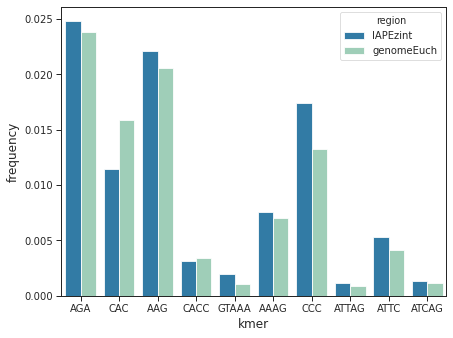

In [47]:
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    fig, ax = plt.subplots(figsize = (6.4, 4.8), tight_layout = True)
    sns.barplot(
        data = top10kmer_freq_df,
        y = 'frequency',
        x = 'kmer', 
        hue = 'region',
        palette = 'YlGnBu_r',
        orient = 'v')
    # ax.set_xlim(0,20000)
#     ax.set_xscale('log')
    # ax.set_xlabel('Number of peaks')
    fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make10_bar_top10kmerFreq_IAP_genome.pdf',transparent=True)
     
